In [1]:
import requests
import json
import numpy as np
import cvxopt.solvers
import datetime
from dateutil.relativedelta import *

In [2]:
cvxopt.solvers.options['show_progress'] = False

In [3]:
class server_api:
    def __init__(self, user='', pwd=''):
        self.url = 'https://dolphin.jump-technology.com:3389/api/v1/'
        self.s = requests.Session()
        self.s.auth = (user, pwd)
        self.s.headers.update({'x-test': 'true'})
    def expand_params(self, req, params):
        request = ''
        if type(params) is tuple:
            request = self.url + (req.format(*params))
        else:
            request = self.url + (req.format(params))
        return request
    def get(self, req, params):
        request = self.expand_params(req, params)
        self.res = ''
        try:
            self.data = self.s.get(request, headers={'x-test2': 'true'}, verify=False)
            self.res = json.loads(self.data.text)
        except:
            print('Error while connecting')
        return self.res
    def post(self, req, params, body):
        request = self.expand_params(req, params)
        self.res = ''
        try:
            self.data = self.s.post(url=request, data=json.dumps(body), headers={'x-test2': 'true'}, verify=False)
            self.res = json.loads(self.data.text)
        except Exception as err:
            print(err)
            print('Error while connecting')
        return self.res
    def get_cached(self):
        return self.res

In [4]:
server = server_api('epita_user_7', 'dolphin19423')

In [26]:
class portfolio_manager:
    def __init__(self, date_begin, date_end, nb_assets=20):
        print('Getting all assets...')
        self.all_assets = server.get('asset', ())
        
        self.nb_assets = nb_assets
        
        self.ids = []
        for i in self.all_assets:
            self.ids.append(int(i['ASSET_DATABASE_ID']['value']))

        self.real_assets_nb = len(self.ids)
        print('Received', self.real_assets_nb, 'assets.')

        self.date_b = datetime.datetime(*date_begin)
        self.date_e = datetime.datetime(*date_end)

        date_len = self.date_e - self.date_b

        self.assets = []
        #off = 0
        #i = beg
        self.names = []
        
        self.asset = []
        
        """obj = {'ratio':[21],'asset': [i for i in range(beg, nb_assets)],'start_date':date_b.isoformat(),'end_date':date_e.isoformat(),
               'frequency':'monthly'}
        self.asset = server.post('ratio/invoke', (), obj)
        while len(self.asset) < nb_assets:
            off += nb_assets - len(self.asset)

            obj = {'ratio':[21],'asset': [i for i in range(beg, off)],'start_date':date_b.isoformat(),'end_date':date_e.isoformat(),
               'frequency':'monthly'}
            self.asset = server.post('ratio/invoke', (), obj)
        """
        
        print('Getting the chosen assets\' monthly returns/sharpe ratios...')
        self.max_size = 0
        ratios = [20, 21]
        self.date_b2 = self.date_b
        while self.date_b2 < self.date_e:
            self.max_size += 1
            date_b_tmp = self.date_b2
            self.date_b2 += relativedelta(months=+1)
            print('Retrieving ', len(self.ids), 'ratios at date ', self.date_b2, '...')
            obj = {'ratio': ratios,'asset': self.ids,'start_date':date_b_tmp.isoformat(),'end_date':self.date_b2.isoformat(),
               'frequency':'monthly'}
            data = server.post('ratio/invoke', (), obj)
            #print(data)
            self.assets.append(data)

    def get_assets(self):
        return self.assets

In [27]:
    def choose_best_assets(self, size=0):
        self.real_assets_nb = 528
        if size != 0:
            self.real_assets_nb = size
        
        self.r = np.zeros((self.max_size, self.real_assets_nb))
        self.sharpes = np.zeros((self.max_size, self.real_assets_nb))
        print(self.r.shape)
        print(len(self.assets))
        print(self.nb_assets)
        print(self.real_assets_nb)
        print('max', self.max_size)
        i = 0
        j = 0
        for ass in self.assets:
            j = 0
            for k, v in ass.items():
                if j == self.real_assets_nb - 1:
                    break
                if '20' in v:
                    self.sharpes[i][j] = float(v['20']['value'].replace(',', '.'))
                else:
                    self.sharpes[i][j] = 0.0
                self.r[i][j] = float(v['21']['value'].replace(',', '.'))
                #if self.r[i][j] == 0.0:
                #print(i, j, self.sharpes[i][j], self.r[i][j])
                #print(i, j, float(v['21']['value'].replace(',', '.')))
                j += 1
            i += 1

        sharpe_means_idx = np.argsort([np.mean(self.sharpes[:, i]) for i in range(self.real_assets_nb)])[:self.nb_assets]
        print(sharpe_means_idx)
        self.assets_rets = []
        print(self.date_b.strftime('%Y-%m-%d'))
        print(self.date_e.strftime('%Y-%m-%d'))
        for i in sharpe_means_idx:
            asset = server.get('asset/{}/quote?start_date={}&end_date={}', (i, self.date_b.strftime('%Y-%m-%d'), self.date_e.strftime('%Y-%m-%d')))
            print(asset)
            self.assets_rets.append(np.array(asset))
            
        self.r = self.r[:, sharpe_means_idx]

        print(self.r)
        
        print(self.real_assets_nb)

    portfolio_manager.choose_best_assets = choose_best_assets

In [28]:
    def compute_means_and_cov(self):
        self.assets_means = []
        rets = []

        self.assets_rets = np.array(self.assets_rets)
        print(self.assets_rets.shape)
        print(self.assets_rets)
        min_size = 9999999999
        print('Computing means and cov for', self.r.shape[1], 'assets')
        print(self.r.shape)
        for asset in range(self.assets_rets.shape[0]):
            #print(self.assets[asset].shape)
            returns = [self.assets_rets[asset][i]['return'] for i in range(self.assets_rets[asset].shape[0])]
            min_size = min(min_size, len(returns))
            rets.append(np.array(returns))
            mean_ret = np.mean(returns)
            self.assets_means.append(mean_ret)
            print('mean', mean_ret)
            print('rets', returns)

        rets = np.array(rets)

        #self.assets_means = np.array(self.assets_means)

        print(min_size)

        self.rets_norm = []
        for asset in range(self.assets_rets.shape[0]):
            self.rets_norm.append(rets[asset][:min_size])

        self.rets_norm = np.array(self.rets_norm)
        self.cov = np.cov(self.rets_norm)
        
        #print(self.cov.shape)
        
        return (np.array(self.assets_means), self.cov)
    
    portfolio_manager.compute_means_and_cov = compute_means_and_cov

In [29]:
    def precompute_data(self):
        self.means, self.cov = p_m.compute_means_and_cov()
        
        print(self.means.shape[0])
        m = self.means.shape[0]
        
        #print(m)
        r_min = 0.1
        
        print(self.cov.shape)
        self.P = cvxopt.matrix(self.cov)

        self.A = cvxopt.matrix(np.ones(m), (1, m), 'd')
        self.b = cvxopt.matrix(1.0)
        
        hard_G = -np.identity(m)
        soft_G = np.identity(m)
        self.G = cvxopt.matrix(np.vstack((hard_G, soft_G)))

        hard_h = -np.ones(m) * 0.01
        soft_h = np.ones(m) * 0.1
        self.h = cvxopt.matrix(np.hstack((hard_h, soft_h)))
        
        #self.G = cvxopt.matrix(-np.identity(m))
        #self.h = cvxopt.matrix(np.ones(m), (m, 1))
    
    portfolio_manager.precompute_data = precompute_data

In [30]:
def find_portfolio(self, risk_tolerance = 1.0):

        #print((-0.5 * risk_tolerance * means).shape)
        #s = [cvxopt.solvers.qp(self.P, cvxopt.matrix(-0.5 * () * means), self.G, self.h, self.A, self.b)['x'] for i in range(nb_possible_portfolio)]

        m = self.means.shape[0]
        #print('Optimizing', m, 'assets with a risk tolerance of ', risk_tolerance)
        #s = cvxopt.solvers.qp(self.P, cvxopt.matrix(-0.5 * risk_tolerance * self.means), self.G, self.h, self.A, self.b)['x']
        s = cvxopt.solvers.qp(risk_tolerance * self.P, cvxopt.matrix(-self.means), self.G, self.h, self.A, self.b)['x']
        return np.array(s)

portfolio_manager.find_portfolio = find_portfolio

In [11]:
p_m = portfolio_manager((2012, 1, 1), (2017, 6, 1), 20)

Getting all assets...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Received 528 assets.
Getting the chosen assets' monthly returns/sharpe ratios...
Retrieving  528 ratios at date  2012-02-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  528 ratios at date  2012-03-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  528 ratios at date  2012-04-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  528 ratios at date  2012-05-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  528 ratios at date  2012-06-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  528 ratios at date  2012-07-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  528 ratios at date  2012-08-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  528 ratios at date  2012-09-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  528 ratios at date  2012-10-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  528 ratios at date  2012-11-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  528 ratios at date  2012-12-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  528 ratios at date  2013-01-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  528 ratios at date  2013-02-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  528 ratios at date  2013-03-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  528 ratios at date  2013-04-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  528 ratios at date  2013-05-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  528 ratios at date  2013-06-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  528 ratios at date  2013-07-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  528 ratios at date  2013-08-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  528 ratios at date  2013-09-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  528 ratios at date  2013-10-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  528 ratios at date  2013-11-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  528 ratios at date  2013-12-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  528 ratios at date  2014-01-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  528 ratios at date  2014-02-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  528 ratios at date  2014-03-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  528 ratios at date  2014-04-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  528 ratios at date  2014-05-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  528 ratios at date  2014-06-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  528 ratios at date  2014-07-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  528 ratios at date  2014-08-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  528 ratios at date  2014-09-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  528 ratios at date  2014-10-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  528 ratios at date  2014-11-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  528 ratios at date  2014-12-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  528 ratios at date  2015-01-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  528 ratios at date  2015-02-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  528 ratios at date  2015-03-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  528 ratios at date  2015-04-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  528 ratios at date  2015-05-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  528 ratios at date  2015-06-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  528 ratios at date  2015-07-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  528 ratios at date  2015-08-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  528 ratios at date  2015-09-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  528 ratios at date  2015-10-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  528 ratios at date  2015-11-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  528 ratios at date  2015-12-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  528 ratios at date  2016-01-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  528 ratios at date  2016-02-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  528 ratios at date  2016-03-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  528 ratios at date  2016-04-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  528 ratios at date  2016-05-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  528 ratios at date  2016-06-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  528 ratios at date  2016-07-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  528 ratios at date  2016-08-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  528 ratios at date  2016-09-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  528 ratios at date  2016-10-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  528 ratios at date  2016-11-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  528 ratios at date  2016-12-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  528 ratios at date  2017-01-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  528 ratios at date  2017-02-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  528 ratios at date  2017-03-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  528 ratios at date  2017-04-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  528 ratios at date  2017-05-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  528 ratios at date  2017-06-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


In [43]:
p_m.choose_best_assets(100)

(65, 100)
65
20
100
max 65
[77 36 69 54 91 59 10 27 35 29 25 78 62 26 76 11 99 94 75 66]
2012-01-01
2017-06-01


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


[{'volume': 283067.0, 'nav': 45.96, 'gross': 45.96, 'pl': 0.5700000000000003, 'bid': 45.95, 'ask': 45.96, 'feed_source': 3.0, 'open': 46.49, 'low': 45.7, 'close': 45.96, 'high': 46.56, 'return': 0.012557832121612695, 'date': '2012-01-03'}, {'volume': 176507.0, 'nav': 45.82, 'gross': 45.82, 'pl': -0.14000000000000057, 'bid': 45.82, 'ask': 45.83, 'feed_source': 3.0, 'open': 45.71, 'low': 45.45, 'close': 45.82, 'high': 46.2, 'return': -0.003046127067014808, 'date': '2012-01-04'}, {'volume': 304738.0, 'nav': 46.21, 'gross': 46.21, 'pl': 0.39000000000000057, 'bid': 46.22, 'ask': 46.23, 'feed_source': 3.0, 'open': 45.47, 'low': 45.0, 'close': 46.21, 'high': 46.33, 'return': 0.008511567001309485, 'date': '2012-01-05'}, {'volume': 254189.0, 'nav': 46.23, 'gross': 46.23, 'pl': 0.01999999999999602, 'bid': 46.24, 'ask': 46.26, 'feed_source': 3.0, 'open': 46.13, 'low': 45.93, 'close': 46.23, 'high': 46.48, 'return': 0.00043280675178524174, 'date': '2012-01-06'}, {'volume': 252132.0, 'nav': 47.02, 

C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


[{'volume': 372920.0, 'nav': 21.64, 'gross': 21.64, 'pl': -0.39000000000000057, 'bid': 21.62, 'ask': 21.64, 'feed_source': 3.0, 'open': 22.0, 'low': 21.28, 'close': 21.64, 'high': 22.13, 'return': -0.017703132092601024, 'date': '2012-01-03'}, {'volume': 597441.0, 'nav': 20.8, 'gross': 20.8, 'pl': -0.8399999999999999, 'bid': 20.79, 'ask': 20.8, 'feed_source': 3.0, 'open': 21.5, 'low': 20.7, 'close': 20.8, 'high': 21.5, 'return': -0.0388170055452865, 'date': '2012-01-04'}, {'volume': 487902.0, 'nav': 21.29, 'gross': 21.29, 'pl': 0.48999999999999844, 'bid': 21.26, 'ask': 21.27, 'feed_source': 3.0, 'open': 20.65, 'low': 20.65, 'close': 21.29, 'high': 21.57, 'return': 0.02355769230769223, 'date': '2012-01-05'}, {'volume': 610174.0, 'nav': 22.34, 'gross': 22.34, 'pl': 1.0500000000000007, 'bid': 22.34, 'ask': 22.35, 'feed_source': 3.0, 'open': 21.3, 'low': 21.3, 'close': 22.34, 'high': 22.64, 'return': 0.049318929074682986, 'date': '2012-01-06'}, {'volume': 392295.0, 'nav': 21.65, 'gross': 21

C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


[{'volume': 13281.0, 'nav': 231.3, 'gross': 231.3, 'pl': 0.950000000000017, 'bid': 231.25, 'ask': 232.45, 'feed_source': 3.0, 'open': 230.35, 'low': 228.15, 'close': 231.3, 'high': 232.0, 'return': 0.004124158888647784, 'date': '2012-01-02'}, {'volume': 42837.0, 'nav': 235.35, 'gross': 235.35, 'pl': 4.049999999999983, 'bid': 234.55, 'ask': 235.45, 'feed_source': 3.0, 'open': 232.75, 'low': 230.65, 'close': 235.35, 'high': 235.9, 'return': 0.017509727626459068, 'date': '2012-01-03'}, {'volume': 38634.0, 'nav': 238.35, 'gross': 238.35, 'pl': 3.0, 'bid': 238.35, 'ask': 238.6, 'feed_source': 3.0, 'open': 235.2, 'low': 235.2, 'close': 238.35, 'high': 239.9, 'return': 0.012746972594008922, 'date': '2012-01-04'}, {'volume': 24152.0, 'nav': 240.0, 'gross': 240.0, 'pl': 1.6500000000000057, 'bid': 239.05, 'ask': 240.2, 'feed_source': 3.0, 'open': 239.0, 'low': 238.45, 'close': 240.0, 'high': 241.0, 'return': 0.0069225928256765506, 'date': '2012-01-05'}, {'volume': 28609.0, 'nav': 237.6, 'gross':

C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


[{'volume': 76698.0, 'nav': 34.61, 'gross': 34.61, 'pl': 0.7000000000000028, 'bid': 34.535, 'ask': 34.645, 'feed_source': 3.0, 'open': 33.915, 'low': 33.615, 'close': 34.61, 'high': 34.61, 'return': 0.020642878207018666, 'date': '2012-01-02'}, {'volume': 236170.0, 'nav': 35.42, 'gross': 35.42, 'pl': 0.8100000000000023, 'bid': 35.26, 'ask': 35.44, 'feed_source': 3.0, 'open': 34.635, 'low': 34.28, 'close': 35.42, 'high': 35.42, 'return': 0.02340364056631038, 'date': '2012-01-03'}, {'volume': 363545.0, 'nav': 35.385, 'gross': 35.385, 'pl': -0.035000000000003695, 'bid': 35.36, 'ask': 35.385, 'feed_source': 3.0, 'open': 35.42, 'low': 35.275, 'close': 35.385, 'high': 35.7, 'return': -0.0009881422924902228, 'date': '2012-01-04'}, {'volume': 187526.0, 'nav': 34.54, 'gross': 34.54, 'pl': -0.8449999999999989, 'bid': 34.52, 'ask': 34.56, 'feed_source': 3.0, 'open': 35.445, 'low': 34.43, 'close': 34.54, 'high': 35.83, 'return': -0.023880175215486757, 'date': '2012-01-05'}, {'volume': 145604.0, 'na

C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


[{'volume': 1851300.0, 'nav': 2097.0, 'gross': 2097.0, 'pl': -6.0, 'bid': 2095.0, 'ask': 2097.0, 'feed_source': 3.0, 'open': 2122.0, 'low': 2095.0, 'close': 2097.0, 'high': 2124.0, 'return': -0.0028530670470756064, 'date': '2012-01-04'}, {'volume': 1390400.0, 'nav': 2065.0, 'gross': 2065.0, 'pl': -32.0, 'bid': 2065.0, 'ask': 2066.0, 'feed_source': 3.0, 'open': 2081.0, 'low': 2063.0, 'close': 2065.0, 'high': 2085.0, 'return': -0.015259895088221268, 'date': '2012-01-05'}, {'volume': 1192000.0, 'nav': 2060.0, 'gross': 2060.0, 'pl': -5.0, 'bid': 2058.0, 'ask': 2060.0, 'feed_source': 3.0, 'open': 2059.0, 'low': 2042.0, 'close': 2060.0, 'high': 2071.0, 'return': -0.002421307506053269, 'date': '2012-01-06'}, {'volume': 3207600.0, 'nav': 2105.0, 'gross': 2105.0, 'pl': 45.0, 'bid': 2103.0, 'ask': 2105.0, 'feed_source': 3.0, 'open': 2083.0, 'low': 2079.0, 'close': 2105.0, 'high': 2125.0, 'return': 0.021844660194174758, 'date': '2012-01-10'}, {'volume': 2023400.0, 'nav': 2107.0, 'gross': 2107.0, 

C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


[{'volume': 846637.0, 'nav': 60.04, 'gross': 60.04, 'pl': -1.0, 'bid': 60.01, 'ask': 60.02, 'feed_source': 3.0, 'open': 61.81, 'low': 59.96, 'close': 60.04, 'high': 61.87, 'return': -0.0163826998689384, 'date': '2012-01-03'}, {'volume': 676506.0, 'nav': 61.59, 'gross': 61.59, 'pl': 1.5500000000000043, 'bid': 61.62, 'ask': 61.63, 'feed_source': 3.0, 'open': 59.97, 'low': 59.8, 'close': 61.59, 'high': 61.98, 'return': 0.02581612258494344, 'date': '2012-01-04'}, {'volume': 638189.0, 'nav': 61.86, 'gross': 61.86, 'pl': 0.269999999999996, 'bid': 61.82, 'ask': 61.84, 'feed_source': 3.0, 'open': 61.14, 'low': 60.47, 'close': 61.86, 'high': 62.01, 'return': 0.004383828543594675, 'date': '2012-01-05'}, {'volume': 730341.0, 'nav': 62.64, 'gross': 62.64, 'pl': 0.7800000000000011, 'bid': 62.6, 'ask': 62.61, 'feed_source': 3.0, 'open': 62.0, 'low': 61.22, 'close': 62.64, 'high': 62.94, 'return': 0.012609117361784694, 'date': '2012-01-06'}, {'volume': 732284.0, 'nav': 62.86, 'gross': 62.86, 'pl': 0.

C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


[{'volume': 1818443.0, 'nav': 57.42, 'gross': 57.42, 'pl': 0.6700000000000017, 'bid': 57.4, 'ask': 57.42, 'feed_source': 3.0, 'open': 56.69, 'low': 56.54, 'close': 57.42, 'high': 57.42, 'return': 0.011806167400881088, 'date': '2012-01-02'}, {'volume': 3560171.0, 'nav': 57.29, 'gross': 57.29, 'pl': -0.13000000000000256, 'bid': 57.23, 'ask': 57.29, 'feed_source': 3.0, 'open': 57.24, 'low': 56.0, 'close': 57.29, 'high': 57.42, 'return': -0.0022640195053988603, 'date': '2012-01-03'}, {'volume': 2718500.0, 'nav': 56.21, 'gross': 56.21, 'pl': -1.0799999999999983, 'bid': 56.21, 'ask': 56.24, 'feed_source': 3.0, 'open': 56.59, 'low': 56.18, 'close': 56.21, 'high': 57.29, 'return': -0.018851457496945338, 'date': '2012-01-04'}, {'volume': 3460993.0, 'nav': 55.5, 'gross': 55.5, 'pl': -0.7100000000000009, 'bid': 55.5, 'ask': 55.52, 'feed_source': 3.0, 'open': 55.2, 'low': 54.89, 'close': 55.5, 'high': 55.85, 'return': -0.012631204412026345, 'date': '2012-01-05'}, {'volume': 2578344.0, 'nav': 56.25

C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


[{'volume': 452081.0, 'nav': 46.41, 'gross': 46.41, 'pl': 0.7349999999999994, 'bid': 46.355, 'ask': 46.445, 'feed_source': 3.0, 'open': 45.775, 'low': 45.61, 'close': 46.41, 'high': 46.49, 'return': 0.016091954022988495, 'date': '2012-01-02'}, {'volume': 923523.0, 'nav': 47.725, 'gross': 47.725, 'pl': 1.3150000000000048, 'bid': 47.655, 'ask': 47.725, 'feed_source': 3.0, 'open': 46.74, 'low': 46.37, 'close': 47.725, 'high': 48.005, 'return': 0.02833441068735197, 'date': '2012-01-03'}, {'volume': 975905.0, 'nav': 47.265, 'gross': 47.265, 'pl': -0.46000000000000085, 'bid': 47.265, 'ask': 47.35, 'feed_source': 3.0, 'open': 47.5, 'low': 47.13, 'close': 47.265, 'high': 48.235, 'return': -0.009638554216867488, 'date': '2012-01-04'}, {'volume': 815633.0, 'nav': 46.985, 'gross': 46.985, 'pl': -0.28000000000000114, 'bid': 46.985, 'ask': 47.02, 'feed_source': 3.0, 'open': 47.465, 'low': 46.59, 'close': 46.985, 'high': 48.085, 'return': -0.005924045276631781, 'date': '2012-01-05'}, {'volume': 7376

C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


[{'volume': 1132227.0, 'nav': 34.45, 'gross': 34.45, 'pl': 0.6900000000000048, 'bid': 34.43, 'ask': 34.45, 'feed_source': 3.0, 'open': 33.76, 'low': 33.635, 'close': 34.45, 'high': 34.495, 'return': 0.020438388625592562, 'date': '2012-01-02'}, {'volume': 1679578.0, 'nav': 34.755, 'gross': 34.755, 'pl': 0.3049999999999997, 'bid': 34.755, 'ask': 34.76, 'feed_source': 3.0, 'open': 34.545, 'low': 34.175, 'close': 34.755, 'high': 34.88, 'return': 0.008853410740203184, 'date': '2012-01-03'}, {'volume': 1746766.0, 'nav': 34.55, 'gross': 34.55, 'pl': -0.2050000000000054, 'bid': 34.55, 'ask': 34.555, 'feed_source': 3.0, 'open': 34.745, 'low': 34.34, 'close': 34.55, 'high': 34.825, 'return': -0.005898431880305147, 'date': '2012-01-04'}, {'volume': 2375215.0, 'nav': 34.06, 'gross': 34.06, 'pl': -0.4899999999999949, 'bid': 34.06, 'ask': 34.165, 'feed_source': 3.0, 'open': 34.74, 'low': 34.05, 'close': 34.06, 'high': 34.87, 'return': -0.014182344428364541, 'date': '2012-01-05'}, {'volume': 1563646.

C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


[{'volume': 413639.0, 'nav': 25.075, 'gross': 25.075, 'pl': 0.9299999999999997, 'bid': 25.035, 'ask': 25.085, 'feed_source': 3.0, 'open': 24.2, 'low': 24.035, 'close': 25.075, 'high': 25.075, 'return': 0.03851729136467176, 'date': '2012-01-02'}, {'volume': 697314.0, 'nav': 25.25, 'gross': 25.25, 'pl': 0.1750000000000007, 'bid': 25.25, 'ask': 25.27, 'feed_source': 3.0, 'open': 25.01, 'low': 24.73, 'close': 25.25, 'high': 25.45, 'return': 0.006979062811565333, 'date': '2012-01-03'}, {'volume': 732273.0, 'nav': 25.09, 'gross': 25.09, 'pl': -0.16000000000000014, 'bid': 25.085, 'ask': 25.09, 'feed_source': 3.0, 'open': 25.15, 'low': 25.05, 'close': 25.09, 'high': 25.67, 'return': -0.006336633663366342, 'date': '2012-01-04'}, {'volume': 768589.0, 'nav': 24.245, 'gross': 24.245, 'pl': -0.8449999999999989, 'bid': 24.245, 'ask': 24.25, 'feed_source': 3.0, 'open': 25.17, 'low': 24.115, 'close': 24.245, 'high': 25.35, 'return': -0.03367875647668389, 'date': '2012-01-05'}, {'volume': 980753.0, 'na

C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


[{'volume': 1008423.0, 'nav': 30.245, 'gross': 30.245, 'pl': 0.5800000000000018, 'bid': 30.23, 'ask': 30.245, 'feed_source': 3.0, 'open': 29.695, 'low': 29.585, 'close': 30.245, 'high': 30.245, 'return': 0.01955166020562959, 'date': '2012-01-02'}, {'volume': 1624125.0, 'nav': 30.96, 'gross': 30.96, 'pl': 0.7149999999999999, 'bid': 30.945, 'ask': 30.96, 'feed_source': 3.0, 'open': 30.485, 'low': 30.0, 'close': 30.96, 'high': 31.075, 'return': 0.02364027111919325, 'date': '2012-01-03'}, {'volume': 1467767.0, 'nav': 30.27, 'gross': 30.27, 'pl': -0.6900000000000013, 'bid': 30.27, 'ask': 30.325, 'feed_source': 3.0, 'open': 30.93, 'low': 30.14, 'close': 30.27, 'high': 31.0, 'return': -0.022286821705426396, 'date': '2012-01-04'}, {'volume': 1783939.0, 'nav': 29.675, 'gross': 29.675, 'pl': -0.5949999999999989, 'bid': 29.675, 'ask': 29.76, 'feed_source': 3.0, 'open': 30.205, 'low': 29.54, 'close': 29.675, 'high': 30.3, 'return': -0.019656425503799105, 'date': '2012-01-05'}, {'volume': 1867237.0

C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


[{'volume': 3223800.0, 'nav': 1771.0, 'gross': 1771.0, 'pl': 66.0, 'bid': 1768.0, 'ask': 1771.0, 'feed_source': 3.0, 'open': 1743.0, 'low': 1733.0, 'close': 1771.0, 'high': 1780.0, 'return': 0.03870967741935484, 'date': '2012-01-04'}, {'volume': 1880600.0, 'nav': 1742.0, 'gross': 1742.0, 'pl': -29.0, 'bid': 1741.0, 'ask': 1743.0, 'feed_source': 3.0, 'open': 1764.0, 'low': 1741.0, 'close': 1742.0, 'high': 1775.0, 'return': -0.01637492941840768, 'date': '2012-01-05'}, {'volume': 2935800.0, 'nav': 1736.0, 'gross': 1736.0, 'pl': -6.0, 'bid': 1734.0, 'ask': 1737.0, 'feed_source': 3.0, 'open': 1756.0, 'low': 1728.0, 'close': 1736.0, 'high': 1782.0, 'return': -0.003444316877152698, 'date': '2012-01-06'}, {'volume': 3517600.0, 'nav': 1766.0, 'gross': 1766.0, 'pl': 30.0, 'bid': 1765.0, 'ask': 1767.0, 'feed_source': 3.0, 'open': 1750.0, 'low': 1747.0, 'close': 1766.0, 'high': 1793.0, 'return': 0.01728110599078341, 'date': '2012-01-10'}, {'volume': 2689700.0, 'nav': 1772.0, 'gross': 1772.0, 'pl':

C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


[{'volume': 327736.0, 'nav': 88.33, 'gross': 88.33, 'pl': 0.7199999999999989, 'bid': 88.3, 'ask': 88.31, 'feed_source': 3.0, 'open': 89.38, 'low': 87.87, 'close': 88.33, 'high': 89.41, 'return': 0.008218239926948966, 'date': '2012-01-03'}, {'volume': 401945.0, 'nav': 89.93, 'gross': 89.93, 'pl': 1.6000000000000085, 'bid': 89.85, 'ask': 89.87, 'feed_source': 3.0, 'open': 88.36, 'low': 87.79, 'close': 89.93, 'high': 90.39, 'return': 0.018113891090229917, 'date': '2012-01-04'}, {'volume': 362376.0, 'nav': 91.68, 'gross': 91.68, 'pl': 1.75, 'bid': 91.67, 'ask': 91.68, 'feed_source': 3.0, 'open': 89.33, 'low': 89.26, 'close': 91.68, 'high': 91.76, 'return': 0.01945957967307906, 'date': '2012-01-05'}, {'volume': 508059.0, 'nav': 92.25, 'gross': 92.25, 'pl': 0.5699999999999932, 'bid': 92.27, 'ask': 92.29, 'feed_source': 3.0, 'open': 91.98, 'low': 91.77, 'close': 92.25, 'high': 94.83, 'return': 0.00621727748691092, 'date': '2012-01-06'}, {'volume': 316887.0, 'nav': 93.25, 'gross': 93.25, 'pl':

C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


[{'volume': 1671036.0, 'nav': 18.12, 'gross': 18.12, 'pl': 0.5050000000000026, 'bid': 18.055, 'ask': 18.12, 'feed_source': 3.0, 'open': 17.565, 'low': 17.495, 'close': 18.12, 'high': 18.12, 'return': 0.028668748225943945, 'date': '2012-01-02'}, {'volume': 2233842.0, 'nav': 18.305, 'gross': 18.305, 'pl': 0.18499999999999872, 'bid': 18.3, 'ask': 18.305, 'feed_source': 3.0, 'open': 18.21, 'low': 17.76, 'close': 18.305, 'high': 18.305, 'return': 0.01020971302428249, 'date': '2012-01-03'}, {'volume': 2582288.0, 'nav': 17.59, 'gross': 17.59, 'pl': -0.7149999999999999, 'bid': 17.59, 'ask': 17.6, 'feed_source': 3.0, 'open': 18.205, 'low': 17.555, 'close': 17.59, 'high': 18.29, 'return': -0.03906036602021305, 'date': '2012-01-04'}, {'volume': 2789655.0, 'nav': 16.82, 'gross': 16.82, 'pl': -0.7699999999999996, 'bid': 16.82, 'ask': 16.835, 'feed_source': 3.0, 'open': 17.5, 'low': 16.685, 'close': 16.82, 'high': 17.55, 'return': -0.04377487208641271, 'date': '2012-01-05'}, {'volume': 2667603.0, 'n

C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


[{'volume': 871967.0, 'nav': 32.44, 'gross': 32.44, 'pl': 0.37999999999999545, 'bid': 32.43, 'ask': 32.44, 'feed_source': 3.0, 'open': 32.55, 'low': 32.24, 'close': 32.44, 'high': 32.85, 'return': 0.01185277604491564, 'date': '2012-01-03'}, {'volume': 976870.0, 'nav': 32.095, 'gross': 32.095, 'pl': -0.34499999999999886, 'bid': 32.09, 'ask': 32.1, 'feed_source': 3.0, 'open': 32.35, 'low': 31.82, 'close': 32.095, 'high': 32.35, 'return': -0.010635018495684306, 'date': '2012-01-04'}, {'volume': 1118642.0, 'nav': 32.38, 'gross': 32.38, 'pl': 0.2850000000000037, 'bid': 32.37, 'ask': 32.38, 'feed_source': 3.0, 'open': 32.07, 'low': 31.87, 'close': 32.38, 'high': 32.41, 'return': 0.00887988783299591, 'date': '2012-01-05'}, {'volume': 728488.0, 'nav': 32.17, 'gross': 32.17, 'pl': -0.21000000000000085, 'bid': 32.15, 'ask': 32.16, 'feed_source': 3.0, 'open': 32.33, 'low': 32.04, 'close': 32.17, 'high': 32.51, 'return': -0.006485484867202003, 'date': '2012-01-06'}, {'volume': 951163.0, 'nav': 32.

C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


[{'volume': 3411036.0, 'nav': 17.685, 'gross': 17.685, 'pl': 0.4800000000000004, 'bid': 17.6, 'ask': 17.685, 'feed_source': 3.0, 'open': 16.825, 'low': 16.82, 'close': 17.685, 'high': 17.685, 'return': 0.027898866608544057, 'date': '2012-01-02'}, {'volume': 5208781.0, 'nav': 17.6, 'gross': 17.6, 'pl': -0.0849999999999973, 'bid': 17.555, 'ask': 17.6, 'feed_source': 3.0, 'open': 17.6, 'low': 17.04, 'close': 17.6, 'high': 17.625, 'return': -0.004806333050607708, 'date': '2012-01-03'}, {'volume': 4037220.0, 'nav': 17.0, 'gross': 17.0, 'pl': -0.6000000000000014, 'bid': 16.99, 'ask': 17.0, 'feed_source': 3.0, 'open': 17.3, 'low': 16.89, 'close': 17.0, 'high': 17.46, 'return': -0.03409090909090917, 'date': '2012-01-04'}, {'volume': 6797959.0, 'nav': 16.08, 'gross': 16.08, 'pl': -0.9200000000000017, 'bid': 16.075, 'ask': 16.08, 'feed_source': 3.0, 'open': 16.77, 'low': 16.06, 'close': 16.08, 'high': 16.79, 'return': -0.05411764705882363, 'date': '2012-01-05'}, {'volume': 7052455.0, 'nav': 15.5

C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


[{'volume': 1220892.0, 'nav': 47.85, 'gross': 47.85, 'pl': 1.1400000000000006, 'bid': 47.84, 'ask': 47.85, 'feed_source': 3.0, 'open': 47.5, 'low': 47.5, 'close': 47.85, 'high': 48.26, 'return': 0.024405908798972396, 'date': '2012-01-03'}, {'volume': 905093.0, 'nav': 48.0, 'gross': 48.0, 'pl': 0.14999999999999858, 'bid': 47.99, 'ask': 48.0, 'feed_source': 3.0, 'open': 47.65, 'low': 47.5, 'close': 48.0, 'high': 48.05, 'return': 0.0031347962382444845, 'date': '2012-01-04'}, {'volume': 736510.0, 'nav': 48.22, 'gross': 48.22, 'pl': 0.21999999999999886, 'bid': 48.22, 'ask': 48.23, 'feed_source': 3.0, 'open': 47.51, 'low': 47.41, 'close': 48.22, 'high': 48.38, 'return': 0.00458333333333331, 'date': '2012-01-05'}, {'volume': 598512.0, 'nav': 48.21, 'gross': 48.21, 'pl': -0.00999999999999801, 'bid': 48.2, 'ask': 48.21, 'feed_source': 3.0, 'open': 48.2, 'low': 47.86, 'close': 48.21, 'high': 48.39, 'return': -0.00020738282870174223, 'date': '2012-01-06'}, {'volume': 756053.0, 'nav': 48.51, 'gros

C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


[{'volume': 3980053.0, 'nav': 66.83, 'gross': 66.83, 'pl': 0.12000000000000455, 'bid': 66.79, 'ask': 66.8, 'feed_source': 3.0, 'open': 66.27, 'low': 66.27, 'close': 66.83, 'high': 67.0, 'return': 0.0017988307600060643, 'date': '2012-01-03'}, {'volume': 2921155.0, 'nav': 66.8, 'gross': 66.8, 'pl': -0.030000000000001137, 'bid': 66.75, 'ask': 66.77, 'feed_source': 3.0, 'open': 66.6, 'low': 66.34, 'close': 66.8, 'high': 66.88, 'return': -0.00044890019452343465, 'date': '2012-01-04'}, {'volume': 2662749.0, 'nav': 66.52, 'gross': 66.52, 'pl': -0.28000000000000114, 'bid': 66.51, 'ask': 66.52, 'feed_source': 3.0, 'open': 66.47, 'low': 66.25, 'close': 66.52, 'high': 66.65, 'return': -0.004191616766467083, 'date': '2012-01-05'}, {'volume': 2363375.0, 'nav': 66.36, 'gross': 66.36, 'pl': -0.1599999999999966, 'bid': 66.35, 'ask': 66.37, 'feed_source': 3.0, 'open': 66.5, 'low': 65.93, 'close': 66.36, 'high': 66.62, 'return': -0.0024052916416114943, 'date': '2012-01-06'}, {'volume': 2525580.0, 'nav':

C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


[{'volume': 8953243.0, 'nav': 21.97, 'gross': 21.97, 'pl': 0.3299999999999983, 'bid': 21.96, 'ask': 21.97, 'feed_source': 3.0, 'open': 21.9, 'low': 21.85, 'close': 21.97, 'high': 22.0, 'return': 0.015249537892791048, 'date': '2012-01-03'}, {'volume': 6190348.0, 'nav': 21.77, 'gross': 21.77, 'pl': -0.1999999999999993, 'bid': 21.77, 'ask': 21.78, 'feed_source': 3.0, 'open': 21.92, 'low': 21.75, 'close': 21.77, 'high': 21.93, 'return': -0.009103322712790136, 'date': '2012-01-04'}, {'volume': 6847912.0, 'nav': 21.6, 'gross': 21.6, 'pl': -0.16999999999999815, 'bid': 21.59, 'ask': 21.6, 'feed_source': 3.0, 'open': 21.7, 'low': 21.39, 'close': 21.6, 'high': 21.71, 'return': -0.007808911345888753, 'date': '2012-01-05'}, {'volume': 6168794.0, 'nav': 21.56, 'gross': 21.56, 'pl': -0.0400000000000027, 'bid': 21.56, 'ask': 21.57, 'feed_source': 3.0, 'open': 21.74, 'low': 21.56, 'close': 21.56, 'high': 21.78, 'return': -0.0018518518518519768, 'date': '2012-01-06'}, {'volume': 5693844.0, 'nav': 21.82

C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


[{'volume': 227217.0, 'nav': 50.48, 'gross': 50.48, 'pl': 2.384999999999998, 'bid': 50.39, 'ask': 50.59, 'feed_source': 3.0, 'open': 48.53, 'low': 48.095, 'close': 50.48, 'high': 50.71, 'return': 0.04958935440274453, 'date': '2012-01-02'}, {'volume': 412264.0, 'nav': 51.99, 'gross': 51.99, 'pl': 1.5100000000000051, 'bid': 51.95, 'ask': 52.05, 'feed_source': 3.0, 'open': 51.95, 'low': 50.6, 'close': 51.99, 'high': 52.33, 'return': 0.029912836767036554, 'date': '2012-01-03'}, {'volume': 435983.0, 'nav': 52.58, 'gross': 52.58, 'pl': 0.5899999999999963, 'bid': 52.29, 'ask': 52.48, 'feed_source': 3.0, 'open': 51.9, 'low': 51.45, 'close': 52.58, 'high': 53.1, 'return': 0.011348336218503487, 'date': '2012-01-04'}, {'volume': 706953.0, 'nav': 54.24, 'gross': 54.24, 'pl': 1.6600000000000037, 'bid': 54.14, 'ask': 54.15, 'feed_source': 3.0, 'open': 53.0, 'low': 51.86, 'close': 54.24, 'high': 54.24, 'return': 0.03157093952073039, 'date': '2012-01-05'}, {'volume': 581742.0, 'nav': 53.9, 'gross': 53

In [44]:
means, cov = p_m.compute_means_and_cov()
p_m.precompute_data()

(20,)
[ array([ {'volume': 283067.0, 'nav': 45.96, 'gross': 45.96, 'pl': 0.5700000000000003, 'bid': 45.95, 'ask': 45.96, 'feed_source': 3.0, 'open': 46.49, 'low': 45.7, 'close': 45.96, 'high': 46.56, 'return': 0.012557832121612695, 'date': '2012-01-03'},
       {'volume': 176507.0, 'nav': 45.82, 'gross': 45.82, 'pl': -0.14000000000000057, 'bid': 45.82, 'ask': 45.83, 'feed_source': 3.0, 'open': 45.71, 'low': 45.45, 'close': 45.82, 'high': 46.2, 'return': -0.003046127067014808, 'date': '2012-01-04'},
       {'volume': 304738.0, 'nav': 46.21, 'gross': 46.21, 'pl': 0.39000000000000057, 'bid': 46.22, 'ask': 46.23, 'feed_source': 3.0, 'open': 45.47, 'low': 45.0, 'close': 46.21, 'high': 46.33, 'return': 0.008511567001309485, 'date': '2012-01-05'},
       ...,
       {'volume': 282762.0, 'nav': 74.88, 'gross': 74.88, 'pl': 0.0799999999999983, 'bid': 74.88, 'ask': 74.89, 'feed_source': 3.0, 'open': 74.51, 'low': 74.51, 'close': 74.88, 'high': 74.99, 'return': 0.0010695187165775174, 'date': '201

In [45]:
N = 1000
mus = [10**(5.0 * i / N - 1.0) for i in range(N)]
s = [p_m.find_portfolio(mus[i]) for i in range(N)]
s = np.array(s)

In [46]:
R = [np.dot(means, s[i]) for i in range(N)]
R = np.array(R).flatten()

In [47]:
def nearPSD(A,epsilon=0):
   n = A.shape[0]
   eigval, eigvec = np.linalg.eig(A)
   val = np.matrix(np.maximum(eigval,epsilon))
   vec = np.matrix(eigvec)
   T = 1/(np.multiply(vec,vec) * val.T)
   T = np.matrix(np.sqrt(np.diag(np.array(T).reshape((n)) )))
   B = T * vec * np.diag(np.array(np.sqrt(val)).reshape((n)))
   out = B*B.T
   return(out)

In [48]:
cov = np.real(nearPSD(cov))

In [49]:
sigma = [np.sqrt(np.dot(s[i].T, np.dot(cov, s[i]))) for i in range(N)]
sigma = np.array(sigma).flatten()

In [50]:
def opt_port(self, sigma, R):
    m = np.polyfit(R, sigma, 2)
    #print(m)
    x = np.sqrt(m[2] / m[0])
    #print((x * cov))
    s = cvxopt.solvers.qp(cvxopt.matrix(x * cov), -cvxopt.matrix(self.assets_means), self.G, self.h, self.A, self.b)['x']
    return np.array(s)
portfolio_manager.opt_port = opt_port

In [51]:
money = 1e7

In [52]:
opt_port = p_m.opt_port(sigma, R)
w = np.sort(opt_port)
#print(w * 100)
#print(np.sum(w))
print(w * money)
print(np.sum(w * money))

[[ 219461.24360245]
 [ 999994.46440348]
 [ 100033.11470265]
 [ 999989.79854082]
 [ 999992.58720374]
 [ 100003.20893548]
 [ 100005.91865067]
 [ 583694.27437742]
 [ 100082.16772444]
 [ 999990.54839073]
 [ 100006.69203505]
 [ 999990.00286424]
 [ 999985.45436068]
 [ 100004.57924253]
 [ 296760.09837728]
 [ 999989.06190571]
 [ 100004.74168796]
 [ 100006.52174114]
 [ 100010.35949926]
 [ 999995.16175427]]
10000000.0


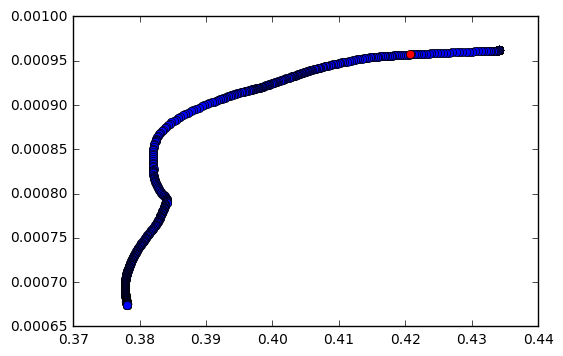

In [53]:
import matplotlib.pyplot as plt

sigma_opt = np.sqrt(np.dot(opt_port.T, np.dot(cov, opt_port)))
R_opt = np.dot(means, opt_port)

plt.plot(sigma, R, 'b-o')
plt.plot(sigma_opt, R_opt, 'ro')
plt.show()